In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from collections import Counter
import json

#Para ML
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Importando CSV

In [2]:
obitos = pd.read_csv('obitos.csv', index_col=False)

# Analisando datasets
## 1- Óbitos por Covid

In [3]:
obitos

,_id,PACIENTE,SEXO,IDADE,MUNICIPIO_RESIDENCIA,DATA_OBITO,COMORBIDADE
0,1,1,M,79,Patos de Minas,2020-03-28T00:00:00,SIM
1,2,2,F,82,Belo Horizonte,2020-03-29T00:00:00,SIM
2,3,3,M,66,Belo Horizonte,2020-03-30T00:00:00,SIM
3,4,4,M,44,Mariana,2020-03-30T00:00:00,NÃO
4,5,5,M,80,Uberlândia,2020-03-30T00:00:00,SIM
...,...,...,...,...,...,...,...
2889,2890,2890,M,86,Andradas,2020-07-30T00:00:00,SIM
2890,2891,2891,F,68,Borda da Mata,2020-07-30T00:00:00,SIM
2891,2892,2892,M,55,Iturama,2020-07-31T00:00:00,Não informado
2892,2893,2893,F,81,Conceição das Alagoas,2020-01-08T00:00:00,Não informado


In [4]:
#Entendendo tipo dos dados
obitos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2894 entries, 0 to 2893
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   _id                   2894 non-null   int64 
 1   PACIENTE              2894 non-null   int64 
 2   SEXO                  2894 non-null   object
 3   IDADE                 2894 non-null   int64 
 4   MUNICIPIO_RESIDENCIA  2894 non-null   object
 5   DATA_OBITO            2823 non-null   object
 6   COMORBIDADE           2894 non-null   object
dtypes: int64(3), object(4)
memory usage: 158.4+ KB


In [5]:
#verificando existência de valores nulos
obitos.isnull().sum()

_id                      0
PACIENTE                 0
SEXO                     0
IDADE                    0
MUNICIPIO_RESIDENCIA     0
DATA_OBITO              71
COMORBIDADE              0
dtype: int64

In [6]:
#removendo valores nulos
obitos = obitos[obitos['DATA_OBITO'].notnull()]

In [7]:
#retirando colunas que não serão usadas
obitos = obitos.loc[:,['IDADE','MUNICIPIO_RESIDENCIA']]
obitos.head()

,IDADE,MUNICIPIO_RESIDENCIA
0,79,Patos de Minas
1,82,Belo Horizonte
2,66,Belo Horizonte
3,44,Mariana
4,80,Uberlândia


In [8]:
#corrigindo coluna MUNICIPIO_RESIDENCIA, deixando maiuscula e sem acentuação

obitos['MUNICIPIO_RESIDENCIA'] = obitos['MUNICIPIO_RESIDENCIA'].str.normalize('NFKD')\
       .str.encode('ascii', errors='ignore')\
       .str.decode('utf-8').astype(str).str.upper()

obitos

,IDADE,MUNICIPIO_RESIDENCIA
0,79,PATOS DE MINAS
1,82,BELO HORIZONTE
2,66,BELO HORIZONTE
3,44,MARIANA
4,80,UBERLANDIA
...,...,...
2889,86,ANDRADAS
2890,68,BORDA DA MATA
2891,55,ITURAMA
2892,81,CONCEICAO DAS ALAGOAS


In [9]:
#agrupando por municipios... média de idade e soma de óbitos por municipio
obitos = obitos.groupby(by = 'MUNICIPIO_RESIDENCIA', as_index = False).agg( {'IDADE':'mean'}).round()
obitos = obitos.rename({'IDADE': 'MEDIA_IDADE_POR_MUNICIPIO'}, axis=1) #renomeando coluna idade
obitos

,MUNICIPIO_RESIDENCIA,MEDIA_IDADE_POR_MUNICIPIO
0,ABADIA DOS DOURADOS,60.0
1,ACAIACA,85.0
2,ACUCENA,60.0
3,AGUANIL,63.0
4,AGUAS FORMOSAS,74.0
...,...,...
393,VERISSIMO,84.0
394,VERMELHO NOVO,64.0
395,VESPASIANO,57.0
396,VISCONDE DO RIO BRANCO,77.0


In [10]:
#Verificando e Removendo duplicatas
print('Linhas antes de remover duplicatas:' ,obitos['MUNICIPIO_RESIDENCIA'].shape[0])
obitos= obitos.drop_duplicates()
print('Linhas depois de remover duplicatas:' ,obitos['MUNICIPIO_RESIDENCIA'].shape[0])

Linhas antes de remover duplicatas: 398
Linhas depois de remover duplicatas: 398


## 2- Casos confirmados por Covid 

In [11]:
casos_confirmados = pd.read_csv('casos confirmados.csv')
casos_confirmados

,_id,URS,MICRO,MACRO,ID,DATA_NOTIFICACAO,CLASSIFICACAO_CASO,SEXO,IDADE,FAIXA_ETARIA,MUNICIPIO_RESIDENCIA,CODIGO,COMORBIDADE,EVOLUCAO,INTERNACAO,UTI,RACA,DATA_ATUALIZACAO,ORIGEM_DA_INFORMACAO
0,1,NaN,NaN,NaN,1,2020-05-15T00:00:00,CASO CONFIRMADO,MASCULINO,0.0,<1ANO,NAO INFORMADO,NaN,NAO INFORMADO,RECUPERADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,2020-08-13T00:00:00,ESUS
1,2,JUIZ DE FORA,JUIZ DE FORA,SUDESTE,2,2020-05-08T00:00:00,CASO CONFIRMADO,MASCULINO,33.0,30 A 39 ANOS,JUIZ DE FORA,313670.0,NAO INFORMADO,RECUPERADO,NAO,NAO,NAO INFORMADO,2020-08-13T00:00:00,ESUS
2,3,GOVERNADOR VALADARES,GOVERNADOR VALADARES,LESTE,3,2020-06-19T00:00:00,CASO CONFIRMADO,FEMININO,25.0,20 A 29 ANOS,GOVERNADOR VALADARES,312770.0,NAO,EM ACOMPANHAMENTO,NAO,NAO,NAO INFORMADO,2020-08-13T00:00:00,ESUS
3,4,NaN,NaN,NaN,4,2020-06-14T00:00:00,CASO CONFIRMADO,MASCULINO,36.0,30 A 39 ANOS,NAO INFORMADO,NaN,NAO INFORMADO,EM ACOMPANHAMENTO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,2020-08-13T00:00:00,ESUS
4,5,TEOFILO OTONI,TEOFILO OTONI/MALACACHETA,NORDESTE,5,2020-06-14T00:00:00,CASO CONFIRMADO,MASCULINO,51.0,50 A 59 ANOS,TEOFILO OTONI,316860.0,NAO INFORMADO,INVESTIGACAO,SIM,NAO,NAO INFORMADO,2020-08-13T00:00:00,SIVEP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46441,46442,UBA,UBA,SUDESTE,46442,2020-07-24T00:00:00,CASO CONFIRMADO,MASCULINO,20.0,20 A 29 ANOS,GUIRICEMA,312900.0,NAO INFORMADO,EM ACOMPANHAMENTO,NAO,NAO,BRANCA,2020-08-13T00:00:00,ESUS
46442,46443,NaN,NaN,NaN,46443,2020-07-28T00:00:00,CASO CONFIRMADO,FEMININO,39.0,30 A 39 ANOS,DIVINA POLIS,NaN,NAO INFORMADO,EM ACOMPANHAMENTO,NAO,NAO,BRANCA,2020-08-13T00:00:00,ESUS
46443,46444,ALFENAS,GUAXUPE,SUL,46444,2020-08-03T00:00:00,CASO CONFIRMADO,FEMININO,39.0,30 A 39 ANOS,MUZAMBINHO,314410.0,NAO INFORMADO,RECUPERADO,NAO,NAO,BRANCA,2020-08-13T00:00:00,ESUS
46444,46445,DIVINOPOLIS,BOM DESPACHO,OESTE,46445,2020-08-06T00:00:00,CASO CONFIRMADO,MASCULINO,27.0,20 A 29 ANOS,BOM DESPACHO,310740.0,NAO INFORMADO,RECUPERADO,NAO,NAO,BRANCA,2020-08-13T00:00:00,ESUS


In [12]:
#Entendendo tipo dos dados
casos_confirmados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46446 entries, 0 to 46445
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   _id                   46446 non-null  int64  
 1   URS                   45238 non-null  object 
 2   MICRO                 45238 non-null  object 
 3   MACRO                 45238 non-null  object 
 4   ID                    46446 non-null  int64  
 5   DATA_NOTIFICACAO      39302 non-null  object 
 6   CLASSIFICACAO_CASO    46446 non-null  object 
 7   SEXO                  46446 non-null  object 
 8   IDADE                 45581 non-null  float64
 9   FAIXA_ETARIA          45552 non-null  object 
 10  MUNICIPIO_RESIDENCIA  46446 non-null  object 
 11  CODIGO                45238 non-null  float64
 12  COMORBIDADE           46446 non-null  object 
 13  EVOLUCAO              46446 non-null  object 
 14  INTERNACAO            46446 non-null  object 
 15  UTI                

In [13]:
#verificando existência de valores nulos
casos_confirmados.isnull().sum()

_id                        0
URS                     1208
MICRO                   1208
MACRO                   1208
ID                         0
DATA_NOTIFICACAO        7144
CLASSIFICACAO_CASO         0
SEXO                       0
IDADE                    865
FAIXA_ETARIA             894
MUNICIPIO_RESIDENCIA       0
CODIGO                  1208
COMORBIDADE                0
EVOLUCAO                   0
INTERNACAO                 0
UTI                        0
RACA                       0
DATA_ATUALIZACAO           0
ORIGEM_DA_INFORMACAO       0
dtype: int64

In [14]:
#retirando valores nulos da coluna 'DATA_OBITO', 'FAIXA_ETARIA' e 'MACRO'
casos_confirmados = casos_confirmados[(casos_confirmados['DATA_NOTIFICACAO'].notnull()) &
                                     (casos_confirmados['FAIXA_ETARIA'].notnull()) &
                                     (casos_confirmados['MACRO'].notnull())]
casos_confirmados.isnull().sum()

_id                     0
URS                     0
MICRO                   0
MACRO                   0
ID                      0
DATA_NOTIFICACAO        0
CLASSIFICACAO_CASO      0
SEXO                    0
IDADE                   0
FAIXA_ETARIA            0
MUNICIPIO_RESIDENCIA    0
CODIGO                  0
COMORBIDADE             0
EVOLUCAO                0
INTERNACAO              0
UTI                     0
RACA                    0
DATA_ATUALIZACAO        0
ORIGEM_DA_INFORMACAO    0
dtype: int64

In [15]:
casos_confirmados

,_id,URS,MICRO,MACRO,ID,DATA_NOTIFICACAO,CLASSIFICACAO_CASO,SEXO,IDADE,FAIXA_ETARIA,MUNICIPIO_RESIDENCIA,CODIGO,COMORBIDADE,EVOLUCAO,INTERNACAO,UTI,RACA,DATA_ATUALIZACAO,ORIGEM_DA_INFORMACAO
1,2,JUIZ DE FORA,JUIZ DE FORA,SUDESTE,2,2020-05-08T00:00:00,CASO CONFIRMADO,MASCULINO,33.0,30 A 39 ANOS,JUIZ DE FORA,313670.0,NAO INFORMADO,RECUPERADO,NAO,NAO,NAO INFORMADO,2020-08-13T00:00:00,ESUS
2,3,GOVERNADOR VALADARES,GOVERNADOR VALADARES,LESTE,3,2020-06-19T00:00:00,CASO CONFIRMADO,FEMININO,25.0,20 A 29 ANOS,GOVERNADOR VALADARES,312770.0,NAO,EM ACOMPANHAMENTO,NAO,NAO,NAO INFORMADO,2020-08-13T00:00:00,ESUS
4,5,TEOFILO OTONI,TEOFILO OTONI/MALACACHETA,NORDESTE,5,2020-06-14T00:00:00,CASO CONFIRMADO,MASCULINO,51.0,50 A 59 ANOS,TEOFILO OTONI,316860.0,NAO INFORMADO,INVESTIGACAO,SIM,NAO,NAO INFORMADO,2020-08-13T00:00:00,SIVEP
5,6,GOVERNADOR VALADARES,GOVERNADOR VALADARES,LESTE,6,2020-06-05T00:00:00,CASO CONFIRMADO,MASCULINO,41.0,40 A 49 ANOS,GOVERNADOR VALADARES,312770.0,NAO,RECUPERADO,NAO,NAO,NAO INFORMADO,2020-08-13T00:00:00,ESUS
6,7,BELO HORIZONTE,BELO HORIZONTE/NOVA LIMA/CAETE,CENTRO,7,2020-05-15T00:00:00,CASO CONFIRMADO,FEMININO,27.0,20 A 29 ANOS,BELO HORIZONTE,310620.0,NAO INFORMADO,RECUPERADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,2020-08-13T00:00:00,ESUS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46440,46441,GOVERNADOR VALADARES,GOVERNADOR VALADARES,LESTE,46441,2020-08-07T00:00:00,CASO CONFIRMADO,MASCULINO,25.0,20 A 29 ANOS,GOVERNADOR VALADARES,312770.0,NAO INFORMADO,RECUPERADO,NAO,NAO,PARDA,2020-08-13T00:00:00,ESUS
46441,46442,UBA,UBA,SUDESTE,46442,2020-07-24T00:00:00,CASO CONFIRMADO,MASCULINO,20.0,20 A 29 ANOS,GUIRICEMA,312900.0,NAO INFORMADO,EM ACOMPANHAMENTO,NAO,NAO,BRANCA,2020-08-13T00:00:00,ESUS
46443,46444,ALFENAS,GUAXUPE,SUL,46444,2020-08-03T00:00:00,CASO CONFIRMADO,FEMININO,39.0,30 A 39 ANOS,MUZAMBINHO,314410.0,NAO INFORMADO,RECUPERADO,NAO,NAO,BRANCA,2020-08-13T00:00:00,ESUS
46444,46445,DIVINOPOLIS,BOM DESPACHO,OESTE,46445,2020-08-06T00:00:00,CASO CONFIRMADO,MASCULINO,27.0,20 A 29 ANOS,BOM DESPACHO,310740.0,NAO INFORMADO,RECUPERADO,NAO,NAO,BRANCA,2020-08-13T00:00:00,ESUS


In [16]:
#retirando colunas que não serão usadas
casos_confirmados = casos_confirmados.loc[:,['MACRO', 'DATA_NOTIFICACAO',
       'CLASSIFICACAO_CASO', 'SEXO', 'IDADE',
       'MUNICIPIO_RESIDENCIA', 'COMORBIDADE', 'EVOLUCAO',
       'INTERNACAO', 'UTI', 'RACA']]
casos_confirmados

,MACRO,DATA_NOTIFICACAO,CLASSIFICACAO_CASO,SEXO,IDADE,MUNICIPIO_RESIDENCIA,COMORBIDADE,EVOLUCAO,INTERNACAO,UTI,RACA
1,SUDESTE,2020-05-08T00:00:00,CASO CONFIRMADO,MASCULINO,33.0,JUIZ DE FORA,NAO INFORMADO,RECUPERADO,NAO,NAO,NAO INFORMADO
2,LESTE,2020-06-19T00:00:00,CASO CONFIRMADO,FEMININO,25.0,GOVERNADOR VALADARES,NAO,EM ACOMPANHAMENTO,NAO,NAO,NAO INFORMADO
4,NORDESTE,2020-06-14T00:00:00,CASO CONFIRMADO,MASCULINO,51.0,TEOFILO OTONI,NAO INFORMADO,INVESTIGACAO,SIM,NAO,NAO INFORMADO
5,LESTE,2020-06-05T00:00:00,CASO CONFIRMADO,MASCULINO,41.0,GOVERNADOR VALADARES,NAO,RECUPERADO,NAO,NAO,NAO INFORMADO
6,CENTRO,2020-05-15T00:00:00,CASO CONFIRMADO,FEMININO,27.0,BELO HORIZONTE,NAO INFORMADO,RECUPERADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO
...,...,...,...,...,...,...,...,...,...,...,...
46440,LESTE,2020-08-07T00:00:00,CASO CONFIRMADO,MASCULINO,25.0,GOVERNADOR VALADARES,NAO INFORMADO,RECUPERADO,NAO,NAO,PARDA
46441,SUDESTE,2020-07-24T00:00:00,CASO CONFIRMADO,MASCULINO,20.0,GUIRICEMA,NAO INFORMADO,EM ACOMPANHAMENTO,NAO,NAO,BRANCA
46443,SUL,2020-08-03T00:00:00,CASO CONFIRMADO,FEMININO,39.0,MUZAMBINHO,NAO INFORMADO,RECUPERADO,NAO,NAO,BRANCA
46444,OESTE,2020-08-06T00:00:00,CASO CONFIRMADO,MASCULINO,27.0,BOM DESPACHO,NAO INFORMADO,RECUPERADO,NAO,NAO,BRANCA


In [17]:
#corrigindo coluna MUNICIPIO_RESIDENCIA, deixando maiuscula e sem acentuação
casos_confirmados = casos_confirmados.apply(lambda x: x.astype(str).str.upper())
casos_confirmados['MUNICIPIO_RESIDENCIA'] = casos_confirmados['MUNICIPIO_RESIDENCIA'].str.normalize('NFKD')\
       .str.encode('ascii', errors='ignore')\
       .str.decode('utf-8')

In [18]:
#Verificando e Removendo duplicatas
print('Casos confirmados')
print('Linhas antes de remover duplicatas:' ,casos_confirmados.shape[0])
casos_confirmados = casos_confirmados.drop_duplicates()
print('Linhas depois de remover duplicatas:' ,casos_confirmados.shape[0])

Casos confirmados
Linhas antes de remover duplicatas: 37274
Linhas depois de remover duplicatas: 34701


## 3- Mortes COVID-19

In [21]:
casos_e_mortes_confirmadas = pd.read_csv('caso.csv', index_col=False)

In [22]:
casos_e_mortes_confirmadas

,date,state,city,place_type,confirmed,deaths,order_for_place,is_last,estimated_population_2019,estimated_population,city_ibge_code,confirmed_per_100k_inhabitants,death_rate
0,2022-03-27,AP,NaN,state,160328,2122,734,True,845731.0,861773.0,16.0,18604.43527,0.0132
1,2022-03-26,AP,NaN,state,160321,2122,733,False,845731.0,861773.0,16.0,18603.62300,0.0132
2,2022-03-25,AP,NaN,state,160314,2122,732,False,845731.0,861773.0,16.0,18602.81072,0.0132
3,2022-03-24,AP,NaN,state,160301,2122,731,False,845731.0,861773.0,16.0,18601.30220,0.0132
4,2022-03-23,AP,NaN,state,160288,2122,730,False,845731.0,861773.0,16.0,18599.79368,0.0132
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2837998,2020-06-23,SP,Óleo,city,1,0,5,False,2496.0,2471.0,3533809.0,40.46945,0.0000
2837999,2020-06-22,SP,Óleo,city,1,0,4,False,2496.0,2471.0,3533809.0,40.46945,0.0000
2838000,2020-06-21,SP,Óleo,city,1,0,3,False,2496.0,2471.0,3533809.0,40.46945,0.0000
2838001,2020-06-20,SP,Óleo,city,1,0,2,False,2496.0,2471.0,3533809.0,40.46945,0.0000


In [23]:
#Entendendo tipo dos dados
casos_e_mortes_confirmadas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838003 entries, 0 to 2838002
Data columns (total 13 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   date                            object 
 1   state                           object 
 2   city                            object 
 3   place_type                      object 
 4   confirmed                       int64  
 5   deaths                          int64  
 6   order_for_place                 int64  
 7   is_last                         bool   
 8   estimated_population_2019       float64
 9   estimated_population            float64
 10  city_ibge_code                  float64
 11  confirmed_per_100k_inhabitants  float64
 12  death_rate                      float64
dtypes: bool(1), float64(5), int64(3), object(4)
memory usage: 262.5+ MB


In [24]:
#Filtrando coluna DATE entre 04/03/2020 e 12/08/2020
casos_e_mortes_confirmadas = casos_e_mortes_confirmadas[(casos_e_mortes_confirmadas['date'] >= '2020-04-03')
                          & (casos_e_mortes_confirmadas['date'] <= '2020-08-12')].sort_values(by=['date'], ascending= True )

In [25]:
#filtrando apenas por cidades
casos_e_mortes_confirmadas = casos_e_mortes_confirmadas[casos_e_mortes_confirmadas['place_type'] == 'city']
#filtrando apenas estado de interesse (MG)
casos_e_mortes_confirmadas = casos_e_mortes_confirmadas[casos_e_mortes_confirmadas['state'] == 'MG']
#filtrando apenas colunas de interesse
casos_e_mortes_confirmadas = casos_e_mortes_confirmadas.loc[:,['city','death_rate']]

In [26]:
#Tabela final com taxa de mortalidade arredondada pelas cidades de MG, no período especificado
casos_e_mortes_confirmadas = (casos_e_mortes_confirmadas.groupby(by=['city'], as_index=False).mean())\
.sort_values('death_rate', ascending = False)

casos_e_mortes_confirmadas['death_rate'] = (casos_e_mortes_confirmadas['death_rate']*100).round(2)

In [27]:
#verificando existência de valores nulos
casos_e_mortes_confirmadas.isnull().sum()

city          0
death_rate    0
dtype: int64

In [28]:
#Normalizando a coluna city, deixando maiuscula e sem acentuação

casos_e_mortes_confirmadas['city'] = casos_e_mortes_confirmadas['city'].str.normalize('NFKD')\
       .str.encode('ascii', errors='ignore')\
       .str.decode('utf-8').astype(str).str.upper()

In [29]:
casos_e_mortes_confirmadas.sort_values(by='city',ascending=True)

,city,death_rate
0,ABADIA DOS DOURADOS,0.47
1,ABAETE,0.29
2,ABRE CAMPO,0.00
3,ACAIACA,10.55
48,ACUCENA,10.76
...,...,...
842,VIRGINOPOLIS,0.00
843,VIRGOLANDIA,0.00
845,VISCONDE DO RIO BRANCO,3.46
847,VOLTA GRANDE,4.91


In [30]:
#Verificando e Removendo duplicatas
print('Linhas antes de remover duplicatas:' ,casos_e_mortes_confirmadas.shape[0])
casos_e_mortes_confirmadas= casos_e_mortes_confirmadas.drop_duplicates()
print('Linhas depois de remover duplicatas:' ,casos_e_mortes_confirmadas.shape[0])

Linhas antes de remover duplicatas: 854
Linhas depois de remover duplicatas: 854


## Unindo Dataframes

In [31]:
#join dos dfs

df = casos_confirmados.merge(obitos, 
                             how = 'left', 
                             on = 'MUNICIPIO_RESIDENCIA', 
                             suffixes=('_casos', '_obitos'))

In [32]:
#verificação de linhas extras no df devido ao join
print(casos_confirmados.merge(obitos, how = 'left', on = 'MUNICIPIO_RESIDENCIA', suffixes=('_casos', '_obitos')).shape)

(34701, 12)


In [33]:
#Substituindo valores Nulos
df = df.fillna(0)
df.isnull().sum()

MACRO                        0
DATA_NOTIFICACAO             0
CLASSIFICACAO_CASO           0
SEXO                         0
IDADE                        0
MUNICIPIO_RESIDENCIA         0
COMORBIDADE                  0
EVOLUCAO                     0
INTERNACAO                   0
UTI                          0
RACA                         0
MEDIA_IDADE_POR_MUNICIPIO    0
dtype: int64

In [34]:
#Verificando o Join
print(df.groupby('MUNICIPIO_RESIDENCIA')['MUNICIPIO_RESIDENCIA'].nunique().sum())
print(obitos.groupby('MUNICIPIO_RESIDENCIA')['MUNICIPIO_RESIDENCIA'].nunique().sum())
print(casos_confirmados.groupby('MUNICIPIO_RESIDENCIA')['MUNICIPIO_RESIDENCIA'].nunique().sum())

664
398
664


In [37]:
#join dos casos de morte

df = df.merge(casos_e_mortes_confirmadas, 
              how = 'left', 
              left_on='MUNICIPIO_RESIDENCIA', 
              right_on='city', 
              suffixes=('_df', '_mortes'))
df

,MACRO,DATA_NOTIFICACAO,CLASSIFICACAO_CASO,SEXO,IDADE,MUNICIPIO_RESIDENCIA,COMORBIDADE,EVOLUCAO,INTERNACAO,UTI,RACA,MEDIA_IDADE_POR_MUNICIPIO,city,death_rate
0,SUDESTE,2020-05-08T00:00:00,CASO CONFIRMADO,MASCULINO,33.0,JUIZ DE FORA,NAO INFORMADO,RECUPERADO,NAO,NAO,NAO INFORMADO,73.0,JUIZ DE FORA,3.27
1,LESTE,2020-06-19T00:00:00,CASO CONFIRMADO,FEMININO,25.0,GOVERNADOR VALADARES,NAO,EM ACOMPANHAMENTO,NAO,NAO,NAO INFORMADO,69.0,GOVERNADOR VALADARES,6.71
2,NORDESTE,2020-06-14T00:00:00,CASO CONFIRMADO,MASCULINO,51.0,TEOFILO OTONI,NAO INFORMADO,INVESTIGACAO,SIM,NAO,NAO INFORMADO,71.0,TEOFILO OTONI,2.85
3,LESTE,2020-06-05T00:00:00,CASO CONFIRMADO,MASCULINO,41.0,GOVERNADOR VALADARES,NAO,RECUPERADO,NAO,NAO,NAO INFORMADO,69.0,GOVERNADOR VALADARES,6.71
4,CENTRO,2020-05-15T00:00:00,CASO CONFIRMADO,FEMININO,27.0,BELO HORIZONTE,NAO INFORMADO,RECUPERADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,72.0,BELO HORIZONTE,2.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34696,LESTE,2020-08-07T00:00:00,CASO CONFIRMADO,MASCULINO,25.0,GOVERNADOR VALADARES,NAO INFORMADO,RECUPERADO,NAO,NAO,PARDA,69.0,GOVERNADOR VALADARES,6.71
34697,SUDESTE,2020-07-24T00:00:00,CASO CONFIRMADO,MASCULINO,20.0,GUIRICEMA,NAO INFORMADO,EM ACOMPANHAMENTO,NAO,NAO,BRANCA,0.0,GUIRICEMA,0.16
34698,SUL,2020-08-03T00:00:00,CASO CONFIRMADO,FEMININO,39.0,MUZAMBINHO,NAO INFORMADO,RECUPERADO,NAO,NAO,BRANCA,85.0,MUZAMBINHO,0.32
34699,OESTE,2020-08-06T00:00:00,CASO CONFIRMADO,MASCULINO,27.0,BOM DESPACHO,NAO INFORMADO,RECUPERADO,NAO,NAO,BRANCA,70.0,BOM DESPACHO,2.99


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34701 entries, 0 to 34700
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   MACRO                      34701 non-null  object 
 1   DATA_NOTIFICACAO           34701 non-null  object 
 2   CLASSIFICACAO_CASO         34701 non-null  object 
 3   SEXO                       34701 non-null  object 
 4   IDADE                      34701 non-null  object 
 5   MUNICIPIO_RESIDENCIA       34701 non-null  object 
 6   COMORBIDADE                34701 non-null  object 
 7   EVOLUCAO                   34701 non-null  object 
 8   INTERNACAO                 34701 non-null  object 
 9   UTI                        34701 non-null  object 
 10  RACA                       34701 non-null  object 
 11  MEDIA_IDADE_POR_MUNICIPIO  34701 non-null  float64
 12  city                       34685 non-null  object 
 13  death_rate                 34685 non-null  flo

# Aplicação Machine Learning

### Igualando amostras da coluna 'UTI'

In [40]:
#verificando a maior quantidade de itens na coluna
from sklearn.utils import resample
df_maior = df[df['UTI'] == 'NAO'] 
print('linhas:' , df_maior.shape[0])

linhas: 22771


In [41]:
#verificando a menor quantidade de itens na coluna
df_menor = df[df['UTI'] == 'SIM'] 
print('linhas:' ,df_menor.shape[0])

linhas: 881


In [42]:
#Igualando a quantidade de entradas de dos dfs
df_unsampled = resample(df_menor, replace = True, n_samples=19372, random_state=123)
df_unsampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19372 entries, 17110 to 610
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   MACRO                      19372 non-null  object 
 1   DATA_NOTIFICACAO           19372 non-null  object 
 2   CLASSIFICACAO_CASO         19372 non-null  object 
 3   SEXO                       19372 non-null  object 
 4   IDADE                      19372 non-null  object 
 5   MUNICIPIO_RESIDENCIA       19372 non-null  object 
 6   COMORBIDADE                19372 non-null  object 
 7   EVOLUCAO                   19372 non-null  object 
 8   INTERNACAO                 19372 non-null  object 
 9   UTI                        19372 non-null  object 
 10  RACA                       19372 non-null  object 
 11  MEDIA_IDADE_POR_MUNICIPIO  19372 non-null  float64
 12  city                       19332 non-null  object 
 13  death_rate                 19332 non-null  f

In [43]:
#Concatenando resultados
df = pd.concat([df_unsampled, df_maior])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42143 entries, 17110 to 34700
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   MACRO                      42143 non-null  object 
 1   DATA_NOTIFICACAO           42143 non-null  object 
 2   CLASSIFICACAO_CASO         42143 non-null  object 
 3   SEXO                       42143 non-null  object 
 4   IDADE                      42143 non-null  object 
 5   MUNICIPIO_RESIDENCIA       42143 non-null  object 
 6   COMORBIDADE                42143 non-null  object 
 7   EVOLUCAO                   42143 non-null  object 
 8   INTERNACAO                 42143 non-null  object 
 9   UTI                        42143 non-null  object 
 10  RACA                       42143 non-null  object 
 11  MEDIA_IDADE_POR_MUNICIPIO  42143 non-null  float64
 12  city                       42089 non-null  object 
 13  death_rate                 42089 non-null 

### Transformação de dados categóricos em números inteiros

In [44]:
#Retirando colunas desnecessárias
df = df.drop(['MACRO','DATA_NOTIFICACAO','CLASSIFICACAO_CASO','city'], axis = 1)

In [45]:
#Verificando dados das colunas
for column in df:
    print(df[column].value_counts())
    print('-----------------------')

#percebe-se que nas colunas 'COMORBIDADE' e 'RACA' temos um grande valore de linhas classificados como "NAO INFORMADO" que
#se equivale a null... como eles representam mais de 33% do total de linhas, vamos retirar essas colunas do df

MASCULINO        23575
FEMININO         18567
NAO INFORMADO        1
Name: SEXO, dtype: int64
-----------------------
39.0     955
38.0     948
50.0     935
42.0     923
36.0     916
        ... 
97.0       3
101.0      2
103.0      1
100.0      1
108.0      1
Name: IDADE, Length: 103, dtype: int64
-----------------------
BELO HORIZONTE                4399
UBERLANDIA                    2786
GOVERNADOR VALADARES          2753
JUIZ DE FORA                  2271
IPATINGA                      1450
                              ... 
CORACAO DE JESUS                 1
JORDANIA                         1
CARVALHOPOLIS                    1
SAO SEBASTIAO DO RIO PRETO       1
UMBURATIBA                       1
Name: MUNICIPIO_RESIDENCIA, Length: 640, dtype: int64
-----------------------
NAO INFORMADO    23863
SIM              10675
NAO               7605
Name: COMORBIDADE, dtype: int64
-----------------------
RECUPERADO           22613
EM ACOMPANHAMENTO    18981
INVESTIGACAO           549
Name: E

In [46]:
#Retirando colunas que possuem muitos dados inválidos
df = df.drop(['COMORBIDADE','RACA'], axis = 1)

In [47]:
#retirando dados inválidos
df = df[df['INTERNACAO'] != 'NAO INFORMADO']
df['INTERNACAO'].value_counts()

SIM    21401
NAO    20721
Name: INTERNACAO, dtype: int64

In [48]:
#retirando dados inválidos
df = df[df['SEXO'] != 'NAO INFORMADO']
df['SEXO'].value_counts()

MASCULINO    23562
FEMININO     18559
Name: SEXO, dtype: int64

In [68]:
#verificando existencia de valores nulos
df.isna().sum()

SEXO                                           0
IDADE                                          0
INTERNACAO                                     0
UTI                                            0
MEDIA_IDADE_POR_MUNICIPIO                      0
                                              ..
MUNICIPIO_RESIDENCIA_VISCONDE DO RIO BRANCO    0
MUNICIPIO_RESIDENCIA_WENCESLAU BRAZ            0
EVOLUCAO_EM ACOMPANHAMENTO                     0
EVOLUCAO_INVESTIGACAO                          0
EVOLUCAO_RECUPERADO                            0
Length: 646, dtype: int64

In [50]:
#removendo valores nulos
df = df[df['death_rate'].notnull()]
df.isna().sum()

SEXO                         0
IDADE                        0
MUNICIPIO_RESIDENCIA         0
EVOLUCAO                     0
INTERNACAO                   0
UTI                          0
MEDIA_IDADE_POR_MUNICIPIO    0
death_rate                   0
dtype: int64

In [51]:
#Verificando dados das colunas
for column in df:
    print(df[column].value_counts())
    print('-----------------------')

MASCULINO    23510
FEMININO     18557
Name: SEXO, dtype: int64
-----------------------
39.0     954
38.0     947
50.0     934
42.0     921
36.0     916
        ... 
97.0       3
101.0      2
103.0      1
100.0      1
108.0      1
Name: IDADE, Length: 103, dtype: int64
-----------------------
BELO HORIZONTE          4398
UBERLANDIA              2786
GOVERNADOR VALADARES    2753
JUIZ DE FORA            2271
IPATINGA                1450
                        ... 
CAREACU                    1
GUARARA                    1
LAMIM                      1
DORESOPOLIS                1
UMBURATIBA                 1
Name: MUNICIPIO_RESIDENCIA, Length: 637, dtype: int64
-----------------------
RECUPERADO           22602
EM ACOMPANHAMENTO    18917
INVESTIGACAO           548
Name: EVOLUCAO, dtype: int64
-----------------------
SIM    21361
NAO    20706
Name: INTERNACAO, dtype: int64
-----------------------
NAO    22735
SIM    19332
Name: UTI, dtype: int64
-----------------------
72.0    6925
70.0    

In [52]:
#Convertendo categorias em 0 e 1
df["SEXO"] = np.where(df["SEXO"] == "FEMININO", 1, 0)
df["INTERNACAO"] = np.where(df["INTERNACAO"] == "SIM", 1, 0)
df["UTI"] = np.where(df["UTI"] == "SIM", 1, 0)
df

,SEXO,IDADE,MUNICIPIO_RESIDENCIA,EVOLUCAO,INTERNACAO,UTI,MEDIA_IDADE_POR_MUNICIPIO,death_rate
17110,0,55.0,PATOS DE MINAS,EM ACOMPANHAMENTO,1,1,69.0,3.45
10790,1,42.0,SAO JOAO DEL REI,RECUPERADO,1,1,73.0,0.99
11329,1,53.0,BELO HORIZONTE,EM ACOMPANHAMENTO,1,1,72.0,2.38
8434,1,65.0,EXTREMA,EM ACOMPANHAMENTO,1,1,63.0,2.39
1327,1,73.0,UBERLANDIA,RECUPERADO,1,1,70.0,3.11
...,...,...,...,...,...,...,...,...
34696,0,25.0,GOVERNADOR VALADARES,RECUPERADO,0,0,69.0,6.71
34697,0,20.0,GUIRICEMA,EM ACOMPANHAMENTO,0,0,0.0,0.16
34698,1,39.0,MUZAMBINHO,RECUPERADO,0,0,85.0,0.32
34699,0,27.0,BOM DESPACHO,RECUPERADO,0,0,70.0,2.99


In [53]:
#Convertendo em números as categorias da coluna 'MUNICIPIO_RESIDENCIA' e 'EVOLUCAO'
df = pd.get_dummies(df, columns=['MUNICIPIO_RESIDENCIA','EVOLUCAO'])
df

,SEXO,IDADE,INTERNACAO,UTI,MEDIA_IDADE_POR_MUNICIPIO,death_rate,MUNICIPIO_RESIDENCIA_ABADIA DOS DOURADOS,MUNICIPIO_RESIDENCIA_ABAETE,MUNICIPIO_RESIDENCIA_ABRE CAMPO,MUNICIPIO_RESIDENCIA_ACAIACA,...,MUNICIPIO_RESIDENCIA_VESPASIANO,MUNICIPIO_RESIDENCIA_VICOSA,MUNICIPIO_RESIDENCIA_VIEIRAS,MUNICIPIO_RESIDENCIA_VIRGEM DA LAPA,MUNICIPIO_RESIDENCIA_VIRGINIA,MUNICIPIO_RESIDENCIA_VISCONDE DO RIO BRANCO,MUNICIPIO_RESIDENCIA_WENCESLAU BRAZ,EVOLUCAO_EM ACOMPANHAMENTO,EVOLUCAO_INVESTIGACAO,EVOLUCAO_RECUPERADO
17110,0,55.0,1,1,69.0,3.45,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10790,1,42.0,1,1,73.0,0.99,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11329,1,53.0,1,1,72.0,2.38,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8434,1,65.0,1,1,63.0,2.39,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1327,1,73.0,1,1,70.0,3.11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34696,0,25.0,0,0,69.0,6.71,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
34697,0,20.0,0,0,0.0,0.16,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
34698,1,39.0,0,0,85.0,0.32,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
34699,0,27.0,0,0,70.0,2.99,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [54]:
# #Pegando a média de idade da faixa etaria de cada paciente confirmado com Covid
# df['FAIXA_ETARIA'] = df['FAIXA_ETARIA'].str[:2]
# df["FAIXA_ETARIA"].replace({"<1": "1"}, inplace=True)
# df[['FAIXA_ETARIA']] = df[["FAIXA_ETARIA"]].apply(pd.to_numeric)
# df[['FAIXA_ETARIA']] = df[['FAIXA_ETARIA']] + 5
df

,SEXO,IDADE,INTERNACAO,UTI,MEDIA_IDADE_POR_MUNICIPIO,death_rate,MUNICIPIO_RESIDENCIA_ABADIA DOS DOURADOS,MUNICIPIO_RESIDENCIA_ABAETE,MUNICIPIO_RESIDENCIA_ABRE CAMPO,MUNICIPIO_RESIDENCIA_ACAIACA,...,MUNICIPIO_RESIDENCIA_VESPASIANO,MUNICIPIO_RESIDENCIA_VICOSA,MUNICIPIO_RESIDENCIA_VIEIRAS,MUNICIPIO_RESIDENCIA_VIRGEM DA LAPA,MUNICIPIO_RESIDENCIA_VIRGINIA,MUNICIPIO_RESIDENCIA_VISCONDE DO RIO BRANCO,MUNICIPIO_RESIDENCIA_WENCESLAU BRAZ,EVOLUCAO_EM ACOMPANHAMENTO,EVOLUCAO_INVESTIGACAO,EVOLUCAO_RECUPERADO
17110,0,55.0,1,1,69.0,3.45,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10790,1,42.0,1,1,73.0,0.99,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11329,1,53.0,1,1,72.0,2.38,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8434,1,65.0,1,1,63.0,2.39,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1327,1,73.0,1,1,70.0,3.11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34696,0,25.0,0,0,69.0,6.71,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
34697,0,20.0,0,0,0.0,0.16,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
34698,1,39.0,0,0,85.0,0.32,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
34699,0,27.0,0,0,70.0,2.99,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Aplicando Modelos de Machine Learning

In [55]:
from sklearn.model_selection import train_test_split
X_train = df.drop('UTI', axis = 1)
Y_train = df['UTI']

In [56]:
#Criando conjuntos de dados de teste e treino
x_treino, x_teste, y_treino, y_teste = train_test_split(X_train, Y_train, test_size = 0.3)

In [57]:
print(x_treino.shape)
print(x_teste.shape)

print(y_treino.shape)
print(y_teste.shape)

(29446, 645)
(12621, 645)
(29446,)
(12621,)


In [58]:
#ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier
#Criação do modelo
modelo = ExtraTreesClassifier(random_state= 42)
modelo.fit(x_treino, y_treino)

#imprimindo resultados
resultado = modelo.score(x_teste, y_teste)
print('Acurácia:', resultado)

#Outras métricas de eficiência do modelo
Train_predict = modelo.predict(x_teste)
print(classification_report(y_teste, Train_predict ))

Acurácia: 0.9806671420648126
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      6783
           1       0.96      1.00      0.98      5838

    accuracy                           0.98     12621
   macro avg       0.98      0.98      0.98     12621
weighted avg       0.98      0.98      0.98     12621



In [59]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
#Criação do modelo
random_forest = RandomForestClassifier(random_state= 42)
random_forest.fit(x_treino, y_treino)

#imprimindo resultados
resultado = random_forest.score(x_teste, y_teste)
print('Acurácia:', resultado)

#Outras métricas de eficiência do modelo
Train_predict = random_forest.predict(x_teste)
print(classification_report(y_teste, Train_predict))

Acurácia: 0.9809840741621108
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      6783
           1       0.96      1.00      0.98      5838

    accuracy                           0.98     12621
   macro avg       0.98      0.98      0.98     12621
weighted avg       0.98      0.98      0.98     12621



In [60]:
#Regressão Logística
from sklearn.linear_model import LogisticRegression
#Criação do modelo
logistic_regression = LogisticRegression(random_state= 42, max_iter=2000)
logistic_regression.fit(x_treino, y_treino)

#imprimindo resultados
resultado = logistic_regression.score(x_teste, y_teste)
print('Acurácia:', resultado)

Train_predict = logistic_regression.predict(x_teste)
print(classification_report(y_teste, Train_predict ))

Acurácia: 0.9519055542350051
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      6783
           1       0.91      1.00      0.95      5838

    accuracy                           0.95     12621
   macro avg       0.95      0.96      0.95     12621
weighted avg       0.96      0.95      0.95     12621



In [61]:
#Naive Bayes
from sklearn.naive_bayes import GaussianNB
#Criação do modelo
naive_bayes = GaussianNB()
naive_bayes.fit(x_treino, y_treino)

#imprimindo resultados
resultado = naive_bayes.score(x_teste, y_teste)
print('Acurácia:', resultado)

Train_predict = naive_bayes.predict(x_teste)
print(classification_report(y_teste, Train_predict ))

Acurácia: 0.5763410189366928
              precision    recall  f1-score   support

           0       1.00      0.21      0.35      6783
           1       0.52      1.00      0.69      5838

    accuracy                           0.58     12621
   macro avg       0.76      0.61      0.52     12621
weighted avg       0.78      0.58      0.51     12621



In [62]:
#KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
#Criação do modelo
neighbors = KNeighborsClassifier()
neighbors.fit(x_treino, y_treino)

#imprimindo resultados
resultado = neighbors.score(x_teste, y_teste)
print('Acurácia:', resultado)

Train_predict = neighbors.predict(x_teste)
print(classification_report(y_teste, Train_predict ))

Acurácia: 0.9534109816971714
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      6783
           1       0.91      1.00      0.95      5838

    accuracy                           0.95     12621
   macro avg       0.95      0.96      0.95     12621
weighted avg       0.96      0.95      0.95     12621



In [63]:
#SGDClassifier
from sklearn.linear_model import SGDClassifier
#Criação do modelo
sgdc = SGDClassifier()
sgdc.fit(x_treino, y_treino)

#imprimindo resultados
resultado = sgdc.score(x_teste, y_teste)
print('Acurácia:', resultado)

Train_predict = sgdc.predict(x_teste)
print(classification_report(y_teste, Train_predict ))

Acurácia: 0.9413675619998415
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      6783
           1       0.91      0.97      0.94      5838

    accuracy                           0.94     12621
   macro avg       0.94      0.94      0.94     12621
weighted avg       0.94      0.94      0.94     12621



In [64]:
#LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#Criação do modelo
disc = LinearDiscriminantAnalysis()
disc.fit(x_treino, y_treino)

#imprimindo resultados
resultado = disc.score(x_teste, y_teste)
print('Acurácia:', resultado)

Train_predict = disc.predict(x_teste)
print(classification_report(y_teste, Train_predict ))

Acurácia: 0.9515093891133825
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      6783
           1       0.91      1.00      0.95      5838

    accuracy                           0.95     12621
   macro avg       0.95      0.95      0.95     12621
weighted avg       0.96      0.95      0.95     12621



# Análise exploratória

## Análise: Óbitos por covid

In [221]:
from collections import Counter
import json

In [222]:
obitos = pd.read_csv('obitos.csv', index_col=False)

In [223]:
obitos.head()

,_id,PACIENTE,SEXO,IDADE,MUNICIPIO_RESIDENCIA,DATA_OBITO,COMORBIDADE
0,1,1,M,79,Patos de Minas,2020-03-28T00:00:00,SIM
1,2,2,F,82,Belo Horizonte,2020-03-29T00:00:00,SIM
2,3,3,M,66,Belo Horizonte,2020-03-30T00:00:00,SIM
3,4,4,M,44,Mariana,2020-03-30T00:00:00,NÃO
4,5,5,M,80,Uberlândia,2020-03-30T00:00:00,SIM


In [224]:
obitos.describe().round(2)

,_id,PACIENTE,IDADE
count,2894.00,2894.00,2894.00
mean,1447.50,1447.50,69.86
std,835.57,835.57,15.12
min,1.00,1.00,0.00
25%,724.25,724.25,61.00
50%,1447.50,1447.50,72.00
75%,2170.75,2170.75,81.00
max,2894.00,2894.00,107.00


In [225]:
#Convetendo coluna DATA_OBITO para datetime
obitos["DATA_OBITO"] = pd.to_datetime(obitos["DATA_OBITO"], format="%Y/%m/%d")
obitos['DATA_OBITO'].info()
obitos.head()

<class 'pandas.core.series.Series'>
RangeIndex: 2894 entries, 0 to 2893
Series name: DATA_OBITO
Non-Null Count  Dtype         
--------------  -----         
2823 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 22.7 KB


,_id,PACIENTE,SEXO,IDADE,MUNICIPIO_RESIDENCIA,DATA_OBITO,COMORBIDADE
0,1,1,M,79,Patos de Minas,2020-03-28,SIM
1,2,2,F,82,Belo Horizonte,2020-03-29,SIM
2,3,3,M,66,Belo Horizonte,2020-03-30,SIM
3,4,4,M,44,Mariana,2020-03-30,NÃO
4,5,5,M,80,Uberlândia,2020-03-30,SIM


In [226]:
#Maior e menor data da coluna DATA_OBITO
print(obitos['DATA_OBITO'].max())
print(obitos['DATA_OBITO'].min())

2020-12-07 00:00:00
2020-01-04 00:00:00


In [227]:
#Quantidade de Municipios do estado de MG
obitos.groupby('MUNICIPIO_RESIDENCIA').MUNICIPIO_RESIDENCIA.nunique().sum()

405

In [228]:
#Quantidade de pessoas em cada genero

from collections import Counter
genero_obitos = Counter(obitos['SEXO'])
genero_obitos

Counter({'M': 1676, 'F': 1218})

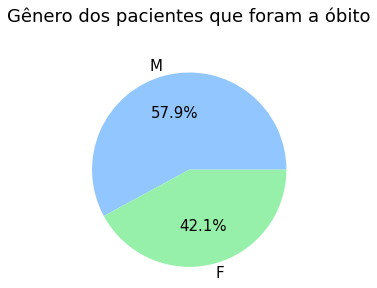

In [229]:
#Quantidade de pessoas em cada genero

from matplotlib import pyplot as plt 
import numpy as np 

plt.style.use('seaborn-pastel')
plt.pie(genero_obitos.values(), labels = genero_obitos.keys(),
autopct = '%1.1f%%', textprops= {'fontsize':15})
plt.title('Gênero dos pacientes que foram a óbito', fontsize=18, pad = 40)
plt.axis('image')
plt.show()

In [230]:
#Quantidade de pessoas que apresentavam comorbidades

from collections import Counter
genero_obitos = Counter(obitos['COMORBIDADE'])
genero_obitos

Counter({'SIM': 2402, 'NÃO': 216, 'Não informado': 276})

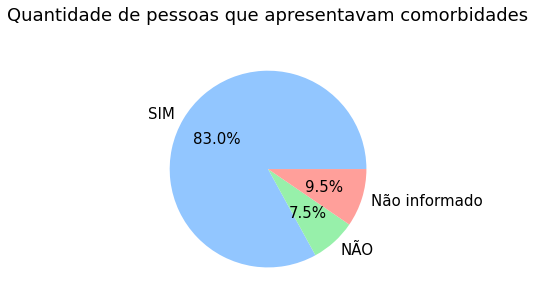

In [231]:
#Quantidade de pessoas que apresentavam comorbidades

from matplotlib import pyplot as plt 
import numpy as np 

plt.style.use('seaborn-pastel')
plt.pie(genero_obitos.values(), labels = genero_obitos.keys(),
autopct = '%1.1f%%', textprops= {'fontsize':15})
plt.title('Quantidade de pessoas que apresentavam comorbidades', fontsize=18, pad = 40)
plt.axis('image')
plt.show()

In [242]:
obitos.IDADE.value_counts()

74     95
68     93
67     89
70     82
84     82
       ..
2       1
17      1
107     1
24      1
14      1
Name: IDADE, Length: 92, dtype: int64

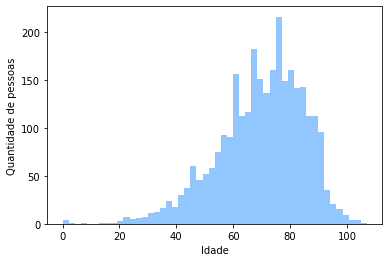

In [238]:
#Histograma de idade a óbito

from matplotlib import pyplot as plt
x = obitos.IDADE
# plt.style.use('ggplot')
plt.xlabel('Idade')
plt.ylabel('Quantidade de pessoas')
plt.hist(x, bins= 50)

plt.show()

In [235]:
#Convertendo categorias em 0 e 1 para análise de correlação
obitos = pd.read_csv('obitos.csv', index_col=False)
obitos["COMORBIDADE"] = np.where(obitos["COMORBIDADE"] == "SIM", 1, 0)
obitos["SEXO"] = np.where(obitos["SEXO"] == "M", 1, 0)
obitos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2894 entries, 0 to 2893
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   _id                   2894 non-null   int64 
 1   PACIENTE              2894 non-null   int64 
 2   SEXO                  2894 non-null   int32 
 3   IDADE                 2894 non-null   int64 
 4   MUNICIPIO_RESIDENCIA  2894 non-null   object
 5   DATA_OBITO            2823 non-null   object
 6   COMORBIDADE           2894 non-null   int32 
dtypes: int32(2), int64(3), object(2)
memory usage: 135.8+ KB


In [236]:
#Plotando correlação entre
import pandas as pd
import numpy as np

obitos = obitos.drop(labels= ['_id','PACIENTE'], axis = 1)

rs = np.random.RandomState(0)
corr = obitos.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=2)


,SEXO,IDADE,COMORBIDADE
SEXO,1.00,-0.09,-0.06
IDADE,-0.09,1.00,0.14
COMORBIDADE,-0.06,0.14,1.00


## Análise: Casos confirmados Covid

In [272]:
casos_confirmados = pd.read_csv('casos confirmados.csv')

In [273]:
casos_confirmados

,_id,URS,MICRO,MACRO,ID,DATA_NOTIFICACAO,CLASSIFICACAO_CASO,SEXO,IDADE,FAIXA_ETARIA,MUNICIPIO_RESIDENCIA,CODIGO,COMORBIDADE,EVOLUCAO,INTERNACAO,UTI,RACA,DATA_ATUALIZACAO,ORIGEM_DA_INFORMACAO
0,1,NaN,NaN,NaN,1,2020-05-15T00:00:00,CASO CONFIRMADO,MASCULINO,0.0,<1ANO,NAO INFORMADO,NaN,NAO INFORMADO,RECUPERADO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,2020-08-13T00:00:00,ESUS
1,2,JUIZ DE FORA,JUIZ DE FORA,SUDESTE,2,2020-05-08T00:00:00,CASO CONFIRMADO,MASCULINO,33.0,30 A 39 ANOS,JUIZ DE FORA,313670.0,NAO INFORMADO,RECUPERADO,NAO,NAO,NAO INFORMADO,2020-08-13T00:00:00,ESUS
2,3,GOVERNADOR VALADARES,GOVERNADOR VALADARES,LESTE,3,2020-06-19T00:00:00,CASO CONFIRMADO,FEMININO,25.0,20 A 29 ANOS,GOVERNADOR VALADARES,312770.0,NAO,EM ACOMPANHAMENTO,NAO,NAO,NAO INFORMADO,2020-08-13T00:00:00,ESUS
3,4,NaN,NaN,NaN,4,2020-06-14T00:00:00,CASO CONFIRMADO,MASCULINO,36.0,30 A 39 ANOS,NAO INFORMADO,NaN,NAO INFORMADO,EM ACOMPANHAMENTO,NAO INFORMADO,NAO INFORMADO,NAO INFORMADO,2020-08-13T00:00:00,ESUS
4,5,TEOFILO OTONI,TEOFILO OTONI/MALACACHETA,NORDESTE,5,2020-06-14T00:00:00,CASO CONFIRMADO,MASCULINO,51.0,50 A 59 ANOS,TEOFILO OTONI,316860.0,NAO INFORMADO,INVESTIGACAO,SIM,NAO,NAO INFORMADO,2020-08-13T00:00:00,SIVEP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46441,46442,UBA,UBA,SUDESTE,46442,2020-07-24T00:00:00,CASO CONFIRMADO,MASCULINO,20.0,20 A 29 ANOS,GUIRICEMA,312900.0,NAO INFORMADO,EM ACOMPANHAMENTO,NAO,NAO,BRANCA,2020-08-13T00:00:00,ESUS
46442,46443,NaN,NaN,NaN,46443,2020-07-28T00:00:00,CASO CONFIRMADO,FEMININO,39.0,30 A 39 ANOS,DIVINA POLIS,NaN,NAO INFORMADO,EM ACOMPANHAMENTO,NAO,NAO,BRANCA,2020-08-13T00:00:00,ESUS
46443,46444,ALFENAS,GUAXUPE,SUL,46444,2020-08-03T00:00:00,CASO CONFIRMADO,FEMININO,39.0,30 A 39 ANOS,MUZAMBINHO,314410.0,NAO INFORMADO,RECUPERADO,NAO,NAO,BRANCA,2020-08-13T00:00:00,ESUS
46444,46445,DIVINOPOLIS,BOM DESPACHO,OESTE,46445,2020-08-06T00:00:00,CASO CONFIRMADO,MASCULINO,27.0,20 A 29 ANOS,BOM DESPACHO,310740.0,NAO INFORMADO,RECUPERADO,NAO,NAO,BRANCA,2020-08-13T00:00:00,ESUS


In [245]:
casos_confirmados.describe().round(2)

,_id,ID,IDADE,CODIGO
count,46446.00,46446.00,45581.00,45238.00
mean,23223.50,23223.50,43.58,313516.00
std,13407.95,13407.95,18.48,2294.36
min,1.00,1.00,0.00,310010.00
25%,11612.25,11612.25,31.00,311330.00
50%,23223.50,23223.50,41.00,313190.00
75%,34834.75,34834.75,55.00,315460.00
max,46446.00,46446.00,220.00,317220.00


In [262]:
#Convetendo coluna DATA_NOTIFICACAO para datetime
casos_confirmados["DATA_NOTIFICACAO"] = pd.to_datetime(\
casos_confirmados["DATA_NOTIFICACAO"], format="%Y/%m/%d")

casos_confirmados['DATA_NOTIFICACAO'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 46446 entries, 0 to 46445
Series name: DATA_NOTIFICACAO
Non-Null Count  Dtype         
--------------  -----         
39302 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 363.0 KB


In [247]:
#Maior e menor data da coluna DATA_NOTIFICACAO
print(casos_confirmados['DATA_NOTIFICACAO'].max())
print(casos_confirmados['DATA_NOTIFICACAO'].min())

2020-08-12 00:00:00
2020-03-04 00:00:00


In [279]:
#Quantidade de Municipios únicos
## 400 a mais que o obitos por covid, o que faz sentido
casos_confirmados.groupby('MUNICIPIO_RESIDENCIA')['MUNICIPIO_RESIDENCIA'].nunique().sum()

868

In [249]:
# a = [numero for numero in genero_obitos][1:]
# json_string = casos_confirmados['MACRO'].value_counts().to_json(orient= 'columns')
# json_object = json.loads(json_string)
# # genero_obitos
# b = [json_object[i] for i in json_object]

In [250]:
# #Regiões na coluna MACRO

#não vou usar pq tem muitas regiões
# from collections import Counter
# genero_obitos = Counter(casos_confirmados['MACRO'])
# genero_obitos

# import matplotlib.pyplot as plt
# fig = plt.figure()
# ax = fig.add_axes([0,0,8,5])
# langs = a
# students = b
# ax.bar(langs,students)
# plt.xticks(fontsize=35, rotation ='vertical')
# plt.yticks(fontsize=35)
# plt.show()

In [251]:
#Quantidade de pessoas em cada genero

from collections import Counter
genero_obitos = Counter(casos_confirmados['SEXO'])
genero_obitos

Counter({'MASCULINO': 24547, 'FEMININO': 21889, 'NAO INFORMADO': 10})

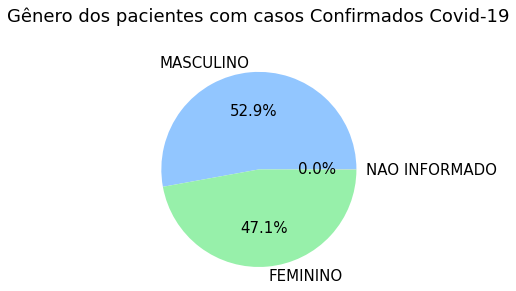

In [252]:
#Quantidade de pessoas em cada genero

from matplotlib import pyplot as plt 
import numpy as np 

plt.style.use('seaborn-pastel')
plt.pie(genero_obitos.values(), labels = genero_obitos.keys(),
autopct = '%1.1f%%', textprops= {'fontsize':15})
plt.title('Gênero dos pacientes com casos Confirmados Covid-19', fontsize=18, pad = 40)
plt.axis('image')
plt.show()

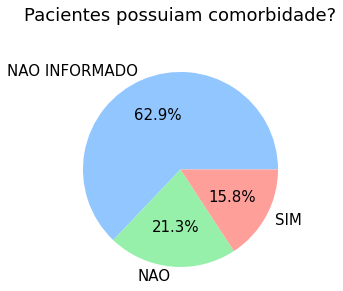

In [253]:
#Quantidade de pessoas que apresentavam comorbidades

from collections import Counter
comorbidade = Counter(casos_confirmados['COMORBIDADE'])
comorbidade

from matplotlib import pyplot as plt 
import numpy as np 

plt.style.use('seaborn-pastel')
plt.pie(comorbidade.values(), labels = comorbidade.keys(),
autopct = '%1.1f%%', textprops= {'fontsize':15})
plt.title('Pacientes possuiam comorbidade?', fontsize=18, pad = 40)
plt.axis('image')
plt.show()

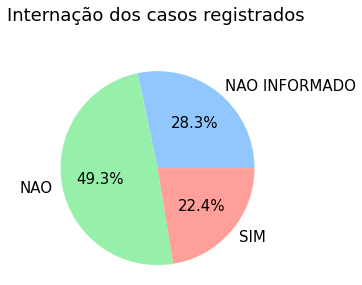

In [254]:
#Internação SIM/NÃO

from collections import Counter
internacao = Counter(casos_confirmados['INTERNACAO'])
internacao

from matplotlib import pyplot as plt 
import numpy as np 

plt.style.use('seaborn-pastel')
plt.pie(internacao.values(), labels = internacao.keys(),
autopct = '%1.1f%%', textprops= {'fontsize':15})
plt.title('Internação dos casos registrados', fontsize=18, pad = 40)
plt.axis('image')
plt.show()

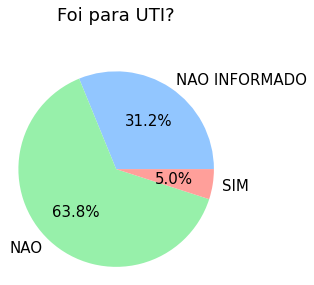

In [255]:
#Foi para UTI?

from collections import Counter
uti = Counter(casos_confirmados['UTI'])

from matplotlib import pyplot as plt 
import numpy as np 

plt.style.use('seaborn-pastel')
plt.pie(uti.values(), labels = uti.keys(),
autopct = '%1.1f%%', textprops= {'fontsize':15})
plt.title('Foi para UTI?', fontsize=18, pad = 40)
plt.axis('image')
plt.show()

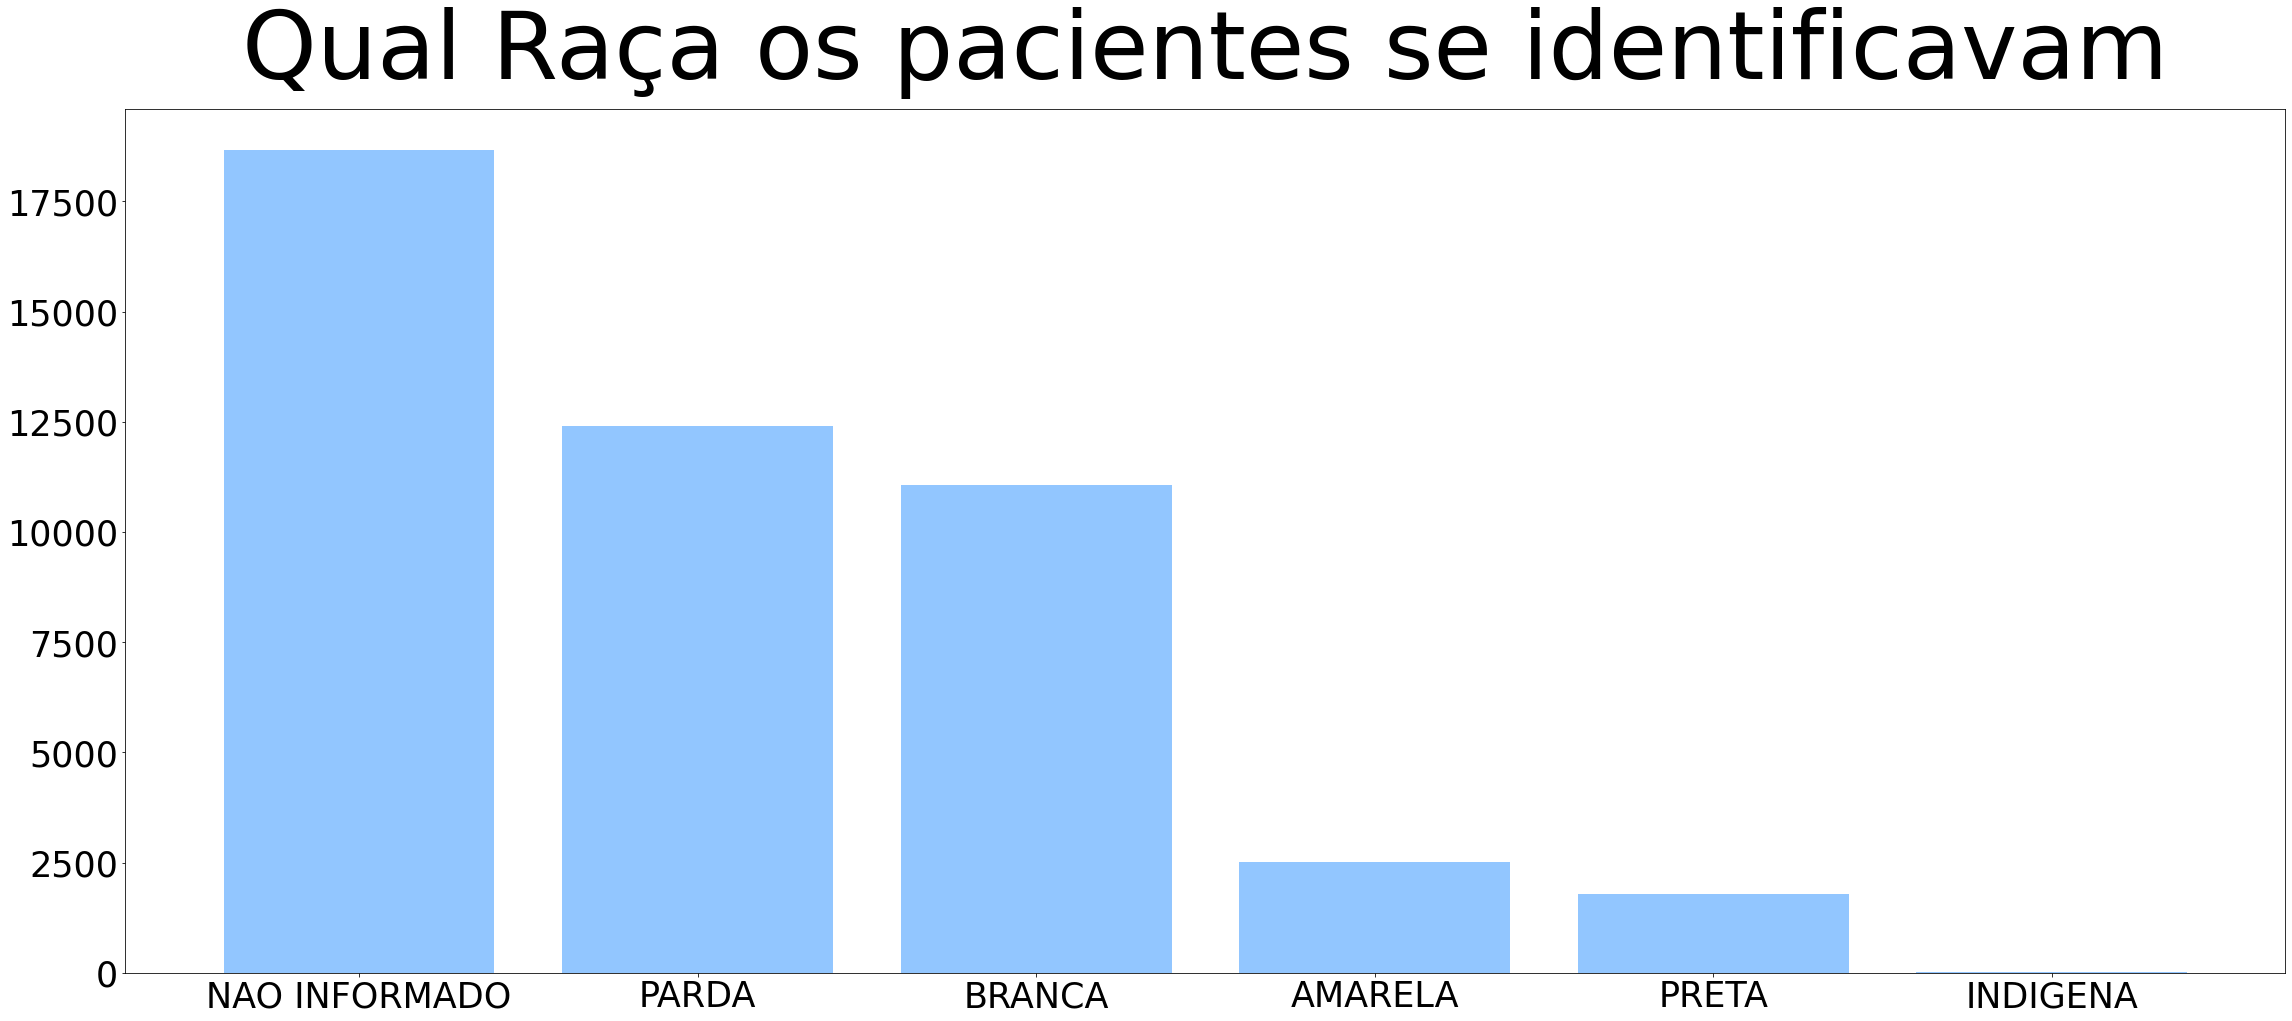

In [283]:
#Qual a Raça os pacientes se identificavam


import json
#Convertendo em Json
json = json.loads(casos_confirmados['RACA'].value_counts().to_json())

a = [i for i in json] #Pegando Keys em lista
b = [json[i] for i in json] #Pegando Values em lista

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
cmap = plt.cm.tab10
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,5,3])
langs = a
students = b
ax.bar(langs,students)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.title('Qual Raça os pacientes se identificavam', fontsize=95, pad = 30)
plt.show()

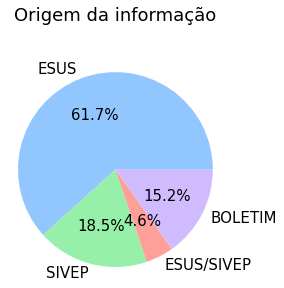

In [257]:
casos_confirmados['ORIGEM_DA_INFORMACAO'].value_counts()

#Origem da informação

from collections import Counter
origem_info = Counter(casos_confirmados['ORIGEM_DA_INFORMACAO'])
origem_info

from matplotlib import pyplot as plt 
import numpy as np 

plt.style.use('seaborn-pastel')
plt.pie(origem_info.values(), labels = origem_info.keys(),
autopct = '%1.1f%%', textprops= {'fontsize':15})
plt.title('Origem da informação', fontsize=18, pad = 40)
plt.axis('image')
plt.show()

## Análise: Mortes por Covid-19

In [306]:
casos_e_mortes_confirmadas.to_excel('C:\\Users\\Gustavo Nassau\\Desktop\\files tcc\\df3.xlsx')

In [301]:
casos_e_mortes_confirmadas.describe().round(2)

,death_rate
count,854.00
mean,3.53
std,9.21
min,0.00
25%,0.00
50%,0.14
75%,2.14
max,76.12


In [287]:
casos_e_mortes_confirmadas['city'].value_counts()

Importados/Indefinidos    10385
Bom Jesus                  2830
São Domingos               2508
Planalto                   2078
Santa Helena               2048
                          ...  
Grupiara                    317
Guidoval                    317
Gurinhatã                   317
Ibertioga                   317
Dona Euzébia                317
Name: city, Length: 5298, dtype: int64